In [1]:
import os, glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm


## 1. Models

- CNN_80x80_2Conv_2Pool_2FC: input 80x80 x3channels; 2 conv, 2 pool, 2 fully connected; output 2 classes
- other to add and try...

In [44]:
class CNN_80x80_2Conv_2Pool_2FC(nn.Module):
    def __init__(self):
        super(CNN_80x80_2Conv_2Pool_2FC, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 20 * 20, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)  # Two output classes: empty and no_empty

        self.dropoutC = nn.Dropout(0.05)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        #x = self.dropoutC(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        #probabilities = F.softmax(x, dim=1)
        return x

In [2]:
class CNN_80x80_3Conv_3Pool_3FC(nn.Module):

    def __init__(self):
        super().__init__()
        # Input size: 100x100
        self.conv1 = nn.Conv2d(3, 16, 5)  # 96
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 48
        self.conv2 = nn.Conv2d(16, 32, 5)  # 44
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 22
        self.conv3 = nn.Conv2d(32, 64, 3)  # 20
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # 10
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 10 * 10, 1000)
        self.fc2 = nn.Linear(1000, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [3]:
class ResNet18(nn.Module):
    """ResNet18 model.
    """

    def __init__(self):
        super().__init__()
        #self.model = models.resnet18(pretrained=True)
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        n = self.model.fc.in_features
        self.model.fc = nn.Linear(n, 2)
        #for param in self.model.parameters():
        #  param.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [4]:
class ResNet50(nn.Module):
    """ResNet50 model.
    """

    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        n = self.model.fc.in_features
        self.model.fc = nn.Linear(n, 12)

    def forward(self, x):
        return self.model(x)

## 2. Prepare and Load dataset

In [5]:
# Change dir in /kaggle
os.chdir('/kaggle')
print("current dir changed to:", os.getcwd())
print(f"listdir: {os.listdir()}")

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

current dir changed to: /kaggle
listdir: ['lib', 'input', 'working']
Device: cuda


Split data into folders according to their class (empty - no_empty), based on the labels written in the corresponding text files.

### Old method

In [ ]:
"""for setname in ['training', 'validation', 'test']:
    print(f"Dividing {setname} data")
    os.makedirs(f'./temp/{setname}/empty/', exist_ok=True)
    os.makedirs(f'./temp/{setname}/no_empty/', exist_ok=True)
    

    for filename in tqdm(os.listdir(f'./input/squares/{setname}_squares/'), desc=f"{setname}", unit="File"):
        if filename.endswith('.png'):

            txt_filename = os.path.join(f'./input/squares/{setname}_squares/', f"{os.path.splitext(filename)[0]}.txt")

            # Verificare se il file di testo contiene "empty"
            with open(txt_filename, 'r') as file:
                if 'empty' in file.read():
                    shutil.copy(os.path.join(f'./input/squares/{setname}_squares/', filename), 
                                os.path.join(f'./temp/{setname}/empty/', filename))
                else:
                    shutil.copy(os.path.join(f'./input/squares/{setname}_squares/', filename), 
                                os.path.join(f'./temp/{setname}/no_empty/', filename))


    num_empty = len(os.listdir(f'./temp/{setname}/empty/'))
    num_no_empty = len(os.listdir(f'./temp/{setname}/no_empty/'))
    print(f"empty: {num_empty} ({num_empty/(num_empty+num_no_empty):.1%})")
    print(f"no_empty: {num_no_empty} ({num_no_empty/(num_empty+num_no_empty):.1%})")"""

Create "data", list of the img paths of the dataset.

Create "labels", list of the corresponding target class label.

Shuffle and split into train, test, validation sets (70-15-15).

In [ ]:
"""class_names = ['empty', 'no_empty']

train_data = []
train_labels = []

validation_data = []
validation_labels = []

test_data = []
test_labels = []

dataset_path = './temp/training'
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        train_data.append(img_path)
        train_labels.append(class_name)

train_data, train_labels = shuffle(train_data, train_labels, random_state=4)

dataset_path = './temp/validation'
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        validation_data.append(img_path)
        validation_labels.append(class_name)

validation_data, validation_labels = shuffle(validation_data, validation_labels, random_state=4)


dataset_path = './temp/test'
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        test_data.append(img_path)
        test_labels.append(class_name)

test_data, test_labels = shuffle(test_data, test_labels, random_state=4)


print(f"training: {len(train_data)}")
print(f"validation: {len(validation_data)}")
print(f"test: {len(test_data)}")"""

### New method (no division in sub dirs)

In [6]:
# Funzione per riempire le liste
def fill_lists(setname, data_list, labels_list):
    print(f"Processing {setname} data")
    
    for filename in tqdm(os.listdir(f'./input/squares/{setname}_squares/'), desc=f"{setname}", unit="File"):
        if filename.endswith('.png'):
            txt_filename = os.path.join(f'./input/squares/{setname}_squares/', f"{os.path.splitext(filename)[0]}.txt")
            img_path = os.path.join(f'./input/squares/{setname}_squares/', filename)
            
            with open(txt_filename, 'r') as file:
                if 'empty' in file.read():
                    data_list.append(img_path)
                    labels_list.append('empty')
                else:
                    data_list.append(img_path)
                    labels_list.append('no_empty')

In [7]:
train_data = []
train_labels = []

validation_data = []
validation_labels = []

test_data = []
test_labels = []

class_names = ['empty', 'no_empty']

# Riempimento delle liste per training, validation e test
fill_lists('training', train_data, train_labels)
fill_lists('validation', validation_data, validation_labels)
fill_lists('test', test_data, test_labels)

# Shuffle dei dati
train_data, train_labels = shuffle(train_data, train_labels, random_state=4)
validation_data, validation_labels = shuffle(validation_data, validation_labels, random_state=4)
test_data, test_labels = shuffle(test_data, test_labels, random_state=4)

# Conteggio delle immagini per ogni set
print(f"training: {len(train_data)}")
print(f"validation: {len(validation_data)}")
print(f"test: {len(test_data)}")

# Conteggio delle classi per ciascun set
num_train_empty = train_labels.count('empty')
num_train_no_empty = train_labels.count('no_empty')
num_val_empty = validation_labels.count('empty')
num_val_no_empty = validation_labels.count('no_empty')
num_test_empty = test_labels.count('empty')
num_test_no_empty = test_labels.count('no_empty')

print(f"Training - empty: {num_train_empty} ({num_train_empty/(num_train_empty+num_train_no_empty):.1%}), no_empty: {num_train_no_empty} ({num_train_no_empty/(num_train_empty+num_train_no_empty):.1%})")
print(f"Validation - empty: {num_val_empty} ({num_val_empty/(num_val_empty+num_val_no_empty):.1%}), no_empty: {num_val_no_empty} ({num_val_no_empty/(num_val_empty+num_val_no_empty):.1%})")
print(f"Test - empty: {num_test_empty} ({num_test_empty/(num_test_empty+num_test_no_empty):.1%}), no_empty: {num_test_no_empty} ({num_test_no_empty/(num_test_empty+num_test_no_empty):.1%})")


Processing training data


training: 100%|██████████| 492672/492672 [18:20<00:00, 447.49File/s]


Processing validation data


validation: 100%|██████████| 15232/15232 [00:32<00:00, 463.73File/s]


Processing test data


test: 100%|██████████| 35968/35968 [01:57<00:00, 304.99File/s]


training: 246336
validation: 7616
test: 17984
Training - empty: 167092 (67.8%), no_empty: 79244 (32.2%)
Validation - empty: 5092 (66.9%), no_empty: 2524 (33.1%)
Test - empty: 12180 (67.7%), no_empty: 5804 (32.3%)


In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = [class_names.index(label) for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Carica l'immagine da file
        img = Image.open(img_path)
        #img = transforms.ToTensor()(img).to(device)
        
        # Applica le trasformazioni se specificate
        if self.transform:
            img = self.transform(img)

        return img, label

In [12]:
transformers = {}

# conv80x80_2_2_2
transformers["CNN_80x80_2Conv_2Pool_2FC"] = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor()
])

# resnet
transformers["ResNet18"] = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


In [45]:
model = CNN_80x80_2Conv_2Pool_2FC()
modelname = model._get_name()

train_ds = CustomDataset(train_data, train_labels, transform=transformers[modelname])
validation_ds = CustomDataset(validation_data, validation_labels, transform=transformers[modelname])
test_ds = CustomDataset(test_data, test_labels, transform=transformers[modelname])

In [46]:
# Crea i dataloader
batch_size = 32

if device == 'cpu':
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
else:
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## 3. Train Model

In [19]:
# Inizializza la rete
#model = ResNet()
model.to(device)

# Learning functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, threshold=0.02, threshold_mode='rel', factor=0.5, verbose=True)

# Training params
epochs = 0
num_epochs = 150
# Early stopping
best_valid_loss = float('inf')
early_stopping_patience = 7  # Sostituisci con il tuo valore desiderato
early_stopping_counter = 0

# Liste per salvare i valori di loss e checkpoint
train_losses = []
validation_losses = []
model_saves_path = './working/'

In [20]:
 # Training della rete
for epoch in range(epochs, num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.to(device))

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Calcola la media della loss sul set di training
    train_loss = running_loss / len(train_dataloader)
    
    # Valutazione sul set di validazione
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            valid_loss += criterion(outputs, labels.to(device))

    # Calcola la media della loss sul set di validazione
    valid_loss /= len(validation_dataloader)

     # Adjust learning rate using the scheduler
    scheduler.step(valid_loss)

    # Aggiorna le liste di loss
    train_losses.append(loss.item())
    validation_losses.append(valid_loss.item())

    # Controlla se la loss sul set di validazione è migliorata
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stopping_counter = 0
    else:
        # Incrementa il contatore di early stopping
        early_stopping_counter += 1

    print(f'Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss.item():.4f}, Patience count: {early_stopping_counter}')

    # Se la loss non migliora per un numero specifico di epoche, interrompi il training
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_counter + 1} epochs without improvement.')
        break

    if not epoch % 2:
      os.makedirs(model_saves_path, exist_ok=True)
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss,
          'valid_loss': valid_loss,
          'early_stopping_counter': early_stopping_counter,
          'train_losses': train_losses,
          'validation_losses': validation_losses,
          }, f"{model_saves_path}{model._get_name()}_transf_stdresnet_b{batch_size}_ep{epoch}.tar")
      print(f"Salvato checkpoint {model_saves_path}{model._get_name()}_transf_stdresnet_b{batch_size}_ep{epoch}.tar")

Epoch 1/150: 100%|██████████| 7698/7698 [09:20<00:00, 13.74batch/s]


Train Loss: 0.0047, Valid Loss: 0.0219, Patience count: 0
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep0.tar


Epoch 2/150: 100%|██████████| 7698/7698 [07:08<00:00, 17.95batch/s]


Train Loss: 0.0018, Valid Loss: 0.0169, Patience count: 0


Epoch 3/150: 100%|██████████| 7698/7698 [07:09<00:00, 17.93batch/s]


Train Loss: 0.0179, Valid Loss: 0.0233, Patience count: 1
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep2.tar


Epoch 4/150: 100%|██████████| 7698/7698 [07:09<00:00, 17.93batch/s]


Train Loss: 0.0034, Valid Loss: 0.0128, Patience count: 0


Epoch 5/150: 100%|██████████| 7698/7698 [07:09<00:00, 17.94batch/s]


Train Loss: 0.0031, Valid Loss: 0.0080, Patience count: 0
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep4.tar


Epoch 6/150: 100%|██████████| 7698/7698 [07:15<00:00, 17.67batch/s]


Train Loss: 0.0027, Valid Loss: 0.0071, Patience count: 0


Epoch 7/150: 100%|██████████| 7698/7698 [07:09<00:00, 17.94batch/s]


Train Loss: 0.0008, Valid Loss: 0.0099, Patience count: 1
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep6.tar


Epoch 8/150: 100%|██████████| 7698/7698 [07:09<00:00, 17.94batch/s]


Train Loss: 0.0081, Valid Loss: 0.0063, Patience count: 0


Epoch 9/150: 100%|██████████| 7698/7698 [07:09<00:00, 17.93batch/s]


Train Loss: 0.0047, Valid Loss: 0.0109, Patience count: 1
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep8.tar


Epoch 10/150: 100%|██████████| 7698/7698 [07:08<00:00, 17.95batch/s]


Train Loss: 0.0031, Valid Loss: 0.0071, Patience count: 2


Epoch 11/150: 100%|██████████| 7698/7698 [07:08<00:00, 17.95batch/s]


Train Loss: 0.0002, Valid Loss: 0.0050, Patience count: 0
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep10.tar


Epoch 12/150: 100%|██████████| 7698/7698 [07:08<00:00, 17.95batch/s]


Train Loss: 0.0004, Valid Loss: 0.0064, Patience count: 1


Epoch 13/150: 100%|██████████| 7698/7698 [07:08<00:00, 17.95batch/s]


Train Loss: 0.0008, Valid Loss: 0.0065, Patience count: 2
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep12.tar


Epoch 14/150: 100%|██████████| 7698/7698 [07:08<00:00, 17.95batch/s]


Train Loss: 0.0012, Valid Loss: 0.0072, Patience count: 3


Epoch 15/150: 100%|██████████| 7698/7698 [16:01<00:00,  8.01batch/s]


Epoch 00015: reducing learning rate of group 0 to 1.0000e-03.
Train Loss: 0.0005, Valid Loss: 0.0061, Patience count: 4
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep14.tar


Epoch 16/150: 100%|██████████| 7698/7698 [31:57<00:00,  4.01batch/s]   


Train Loss: 0.0002, Valid Loss: 0.0056, Patience count: 5


Epoch 17/150: 100%|██████████| 7698/7698 [07:07<00:00, 18.00batch/s]


Train Loss: 0.0005, Valid Loss: 0.0085, Patience count: 6
Salvato checkpoint ./working/ResNet18_transf_stdresnet_b32_ep16.tar


Epoch 18/150: 100%|██████████| 7698/7698 [07:09<00:00, 17.94batch/s]


Train Loss: 0.0033, Valid Loss: 0.0090, Patience count: 7
Early stopping after 18 epochs without improvement.


In [ ]:
import matplotlib.pyplot as plt


# Plot dei valori di training loss e validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim(0, 0.5)
plt.legend()
plt.show()

## 4. Test Model
Test the model on test data and evaluate accuracy

### Se si vuole testare un modello in particolare messo in input, diverso da quello precedente

In [47]:
if True:
    modelpath = "/kaggle/input/cnn-80x80-2conv-2pool-2fc-transf-80x80-ep40/CNN_80x80_2Conv_2Pool_2FC_transf_80x80_ep40.tar"
    
    # inizializzare il modello e optimizer giusti, per poter caricare gli state dict giusti
    model = CNN_80x80_2Conv_2Pool_2FC()
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    if os.path.exists(modelpath):
        checkpoint = torch.load(modelpath, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epochs = checkpoint['epoch']
        loss = checkpoint['loss']
        valid_loss = checkpoint['valid_loss']
        early_stopping_counter = checkpoint['early_stopping_counter']
        train_losses = checkpoint['train_losses']
        validation_losses = checkpoint['validation_losses']
    model.to(device)

### Test accuracy

In [48]:
# Test della rete
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc=f"Testing", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Testing: 100%|██████████| 562/562 [00:08<00:00, 66.17batch/s]

Test Accuracy: 99.56%


### Test completo
Tieni tutte le predictions e true labels dei vari batch, cosi' da avere confusion matrix e altre metriche

Testing: 100%|██████████| 562/562 [00:20<00:00, 27.65batch/s]


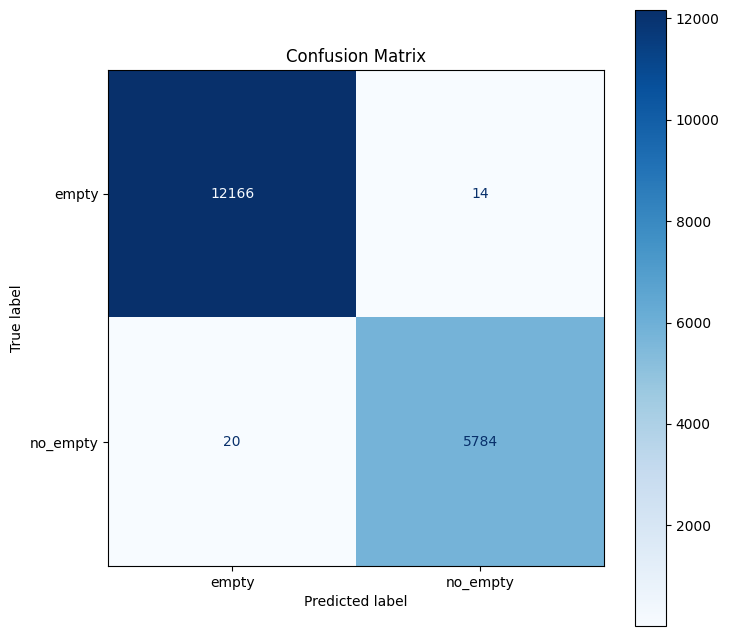

Accuracy: 0.9981
F1 Score: 0.9971
Precision: 0.9976
Recall: 0.9966


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt


model.to(device)
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Testing", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcolo della matrice di confusione
cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Plot della matrice di confusione
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calcola l'accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Calcola l'F1 score
f1 = f1_score(all_labels, all_predictions)

# Calcola la precision
precision = precision_score(all_labels, all_predictions)

# Calcola la recall
recall = recall_score(all_labels, all_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

## 5. Save Model

In [49]:
additional_info = ""

In [50]:
from datetime import datetime

def get_unique_filename(base_filename):
    filename, file_extension = os.path.splitext(base_filename)
    index = 0
    new_filename = base_filename
    while os.path.exists(new_filename):
        new_filename = f"{filename}_{str(index).zfill(4)}{file_extension}"
        index += 1
    return new_filename, index

model_saves_path = './working/'
current_datetime = datetime.now().strftime("%d/%m/%Y %H:%M")

filename_base = f"{model_saves_path}{model._get_name()}{additional_info}"
filename_model, i = get_unique_filename(f"{filename_base}.pth")
filename_model_info, j = get_unique_filename(f"{filename_base}.txt")
if i != j:
  raise Exception(f'Unwanted error on naming files: \n\t{filename_model}\n\t{filename_model_info}')

torch.save(model, f"{filename_model}")
print(f"Saved {filename_model}")

with open(f"{filename_model_info}", "w") as file:
  file.write(f"Acc: {accuracy * 100:.2f}%\n")
  file.write(f"Date: {current_datetime}\n")

  file.write("\nOn data:\n")
  file.write(f"\tTrain: {len(train_data)}\n")
  file.write(f"\tValidation: {len(validation_data)}\n")
  file.write(f"\tTest: {len(test_data)}\n")
print(f"Saved {filename_model_info}")

Saved ./working/CNN_80x80_2Conv_2Pool_2FC.pth
Saved ./working/CNN_80x80_2Conv_2Pool_2FC.txt
